In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch.optim as optim
import torch.nn as nn
from torch.optim import SGD
from sklearn.metrics import accuracy_score

This is the function that will enable us to print the image and its label of index(index)


In [ ]:
def show_image(images, labels, index):
    image = images[index].view(28, 28)  # Reshape the flattened image
    label = labels[index].item()
    figsize=(2, 2)
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

Here we will define the transform that will convert images to .tensors instead of ndarray,also it normalizes the values to [-1,1]


In [ ]:
# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts PIL Image or numpy.ndarray to torch.Tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to range [-1, 1]
])


In this cell we will download the data and use the transform we init in the last cell
also we will split the images and the labels
then we will split the training data into validation (0.2) and training (0.8)

In [ ]:
# Download and load the training data
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)


# Download and load the test data
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)


images, labels = train_dataset.data.float() , train_dataset.targets.long()

# images, labels = train_dataset.data, train_dataset.targets
test_images, test_labels = test_dataset.data.float(), test_dataset.targets.long()



train_images, val_images, train_labels, val_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels)

train_images, train_labels = shuffle(train_images, train_labels, random_state=42)
val_images, val_labels = shuffle(val_images, val_labels, random_state=42)



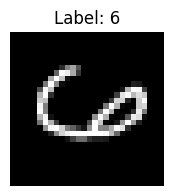

In [ ]:
show_image(val_images,val_labels,10)

Here is the main class that does all the work:input_size, output_size, hidden_layers, activation function dropout_prob

In [ ]:
class FlexibleNN(nn.Module):


    def __init__(self, input_size, output_size, hidden_layers=[128, 64], activation=nn.ReLU(), dropout_prob=0.5):
        super(FlexibleNN, self).__init__()
        layers = []
        for i in range(len(hidden_layers) - 1):
            layers.extend([
                nn.Linear(hidden_layers[i], hidden_layers[i + 1]),
                nn.LayerNorm(hidden_layers[i + 1]),
                activation,
                nn.Dropout(p=dropout_prob)
            ])
        # Input layer
        layers.insert(0, nn.Linear(input_size, hidden_layers[0]))

        # Output layer
        layers.append(nn.Linear(hidden_layers[-1], output_size))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


here is the custom training loop that trains the model using sgd

In [ ]:
def train_model(model, train_loader, criterion, optimizer):

        total_loss = 0.0
        total_samples=0
        correct_predictions=0

        for batch in train_loader:
            images, labels = batch

            # Flatten the images
            images = images.view(images.size(0), -1)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            # Accumulate the total loss for the epoch
            total_loss+=loss.item()
              # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

        accuracy = correct_predictions / total_samples
        return total_loss / len(train_loader),accuracy

This is the validate fn that tests the total loss and accuracy of a provided data

In [ ]:
def validate(model, val_loader, criterion):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
      for inputs, labels in val_loader:
        inputs = inputs.view(inputs.size(0), -1)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)

    return total_loss / len(val_loader), accuracy

here we choose all our hyerparameters and created tendordatasets from our images/labels
also we defined our criterion that specifies the loss

In [ ]:
input_size = 28 * 28
output_size = 10
hidden_layers = [128, 64, 32]
learning_rate = 0.01
num_of_epochs=10

# Create a TensorDataset
dataset = TensorDataset(train_images, train_labels)
val_data = TensorDataset(val_images, val_labels)
test_data = TensorDataset(test_images,test_labels)
# Specify batch size
batch_size = 64

# Create a DataLoader
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
model = FlexibleNN(input_size, output_size, hidden_layers)
print(model)
# Define the criterion
criterion = nn.CrossEntropyLoss()

# Create an SGD optimizer
optimizer = SGD(model.parameters(), lr=learning_rate)


FlexibleNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (3): ReLU()
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=64, out_features=32, bias=True)
    (6): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=32, out_features=10, bias=True)
  )
)


here is the real training that happens

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
# Train the model
for epoch in range(num_of_epochs):
      train_loss, train_accuracy = train_model(model, train_loader, criterion, optimizer)
      val_loss, val_accuracy = validate(model, val_loader, criterion)
      train_accuracies.append(train_accuracy)
      train_losses.append(train_loss)
      val_losses.append(val_loss)
      val_accuracies.append(val_accuracy)

      print("Epoch {}/{}: Train Loss: {:.4f}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}".format(
          epoch + 1, num_of_epochs, train_loss, val_loss, val_accuracy))
# train_model(model, train_loader, criterion, optimizer, num_epochs=num_of_epochs)




Epoch 1/10: Train Loss: 1.4143, Validation Loss: 0.5956, Validation Accuracy: 0.8719
Epoch 2/10: Train Loss: 0.3835, Validation Loss: 0.2732, Validation Accuracy: 0.9285
Epoch 3/10: Train Loss: 0.2340, Validation Loss: 0.2070, Validation Accuracy: 0.9427
Epoch 4/10: Train Loss: 0.1732, Validation Loss: 0.1654, Validation Accuracy: 0.9544
Epoch 5/10: Train Loss: 0.1393, Validation Loss: 0.1455, Validation Accuracy: 0.9589
Epoch 6/10: Train Loss: 0.1167, Validation Loss: 0.1261, Validation Accuracy: 0.9633
Epoch 7/10: Train Loss: 0.0995, Validation Loss: 0.1197, Validation Accuracy: 0.9660
Epoch 8/10: Train Loss: 0.0875, Validation Loss: 0.1119, Validation Accuracy: 0.9682
Epoch 9/10: Train Loss: 0.0769, Validation Loss: 0.1073, Validation Accuracy: 0.9690
Epoch 10/10: Train Loss: 0.0699, Validation Loss: 0.1039, Validation Accuracy: 0.9695


now we will test our model on test set to get final scores

In [ ]:
test_loss, test_accuracy = validate(model, test_loader, criterion)
print(test_loss)
print(test_accuracy)

0.09942378488274374
0.9693


**A fn to plot:**

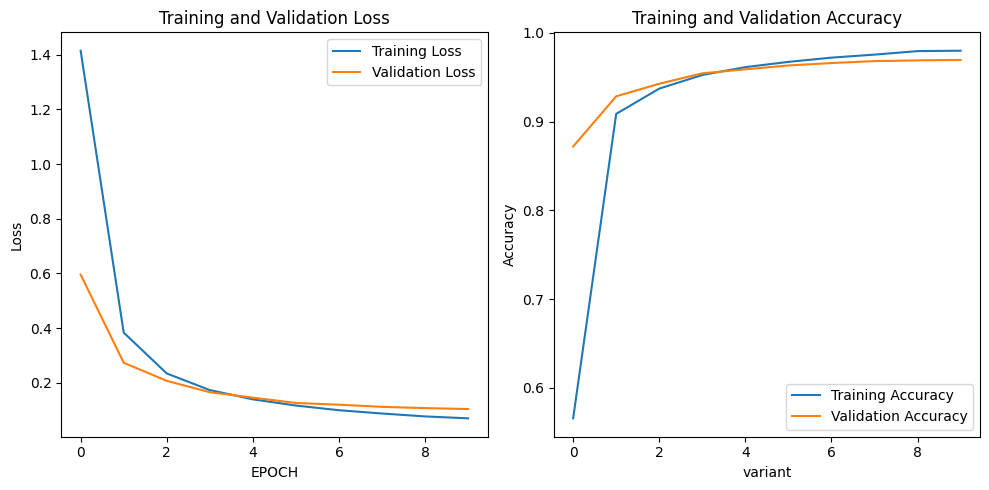

In [ ]:
def Plotting (train_losses,train_accuracies,val_losses,val_accuracies,variant):
  # Plotting training and validation loss
      plt.figure(figsize=(10, 5))
      plt.subplot(1, 2, 1)
      plt.plot(train_losses, label='Training Loss')
      plt.plot(val_losses, label='Validation Loss')
      plt.xlabel(variant)
      plt.ylabel('Loss')
      plt.title('Training and Validation Loss')
      plt.legend()

      # Plotting training and validation accuracy
      plt.subplot(1, 2, 2)
      plt.plot(train_accuracies, label='Training Accuracy')
      plt.plot(val_accuracies, label='Validation Accuracy')
      plt.xlabel('variant')
      plt.ylabel('Accuracy')
      plt.title('Training and Validation Accuracy')
      plt.legend()
      plt.tight_layout()
      plt.show()


Plotting(train_losses=train_losses,train_accuracies=train_accuracies,val_losses=val_losses,val_accuracies=val_accuracies,variant="EPOCH")

as we se as epochs pass our model is learning more and the loss is decreasing for both train and val sets also accuracy is increasing for both

here we will validate the learning rate by trying different rates and catching the acc and loss to plot later

In [ ]:
learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001]
all_train_losses = []
all_train_accuracies = []
all_val_losses = []
all_val_accuracies = []

for lr in learning_rates:
    model = FlexibleNN(input_size, output_size, hidden_layers)
    optimizer = SGD(model.parameters(), lr=lr)
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    for epoch in range(num_of_epochs):
        train_loss,train_accuracy = train_model(model, train_loader, criterion, optimizer)
        val_loss, val_accuracy = validate(model, val_loader, criterion)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)



        print("Epoch {}/{} - Learning Rate: {:.5f}: Train Loss: {:.4f}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}".format(
            epoch + 1, num_of_epochs, lr, train_loss, val_loss, val_accuracy))
              # Append results for the current learning rate to the overall lists
    all_train_losses.append(train_losses)
    all_train_accuracies.append(train_accuracies)
    all_val_losses.append(val_losses)
    all_val_accuracies.append(val_accuracies)


Epoch 1/10 - Learning Rate: 0.10000: Train Loss: 0.9273, Validation Loss: 0.3711, Validation Accuracy: 0.8923
Epoch 2/10 - Learning Rate: 0.10000: Train Loss: 0.2427, Validation Loss: 0.1953, Validation Accuracy: 0.9387
Epoch 3/10 - Learning Rate: 0.10000: Train Loss: 0.1652, Validation Loss: 0.1466, Validation Accuracy: 0.9553
Epoch 4/10 - Learning Rate: 0.10000: Train Loss: 0.1316, Validation Loss: 0.1255, Validation Accuracy: 0.9633
Epoch 5/10 - Learning Rate: 0.10000: Train Loss: 0.1096, Validation Loss: 0.1304, Validation Accuracy: 0.9612
Epoch 6/10 - Learning Rate: 0.10000: Train Loss: 0.0939, Validation Loss: 0.1125, Validation Accuracy: 0.9665
Epoch 7/10 - Learning Rate: 0.10000: Train Loss: 0.0822, Validation Loss: 0.1113, Validation Accuracy: 0.9684
Epoch 8/10 - Learning Rate: 0.10000: Train Loss: 0.0744, Validation Loss: 0.0969, Validation Accuracy: 0.9717
Epoch 9/10 - Learning Rate: 0.10000: Train Loss: 0.0661, Validation Loss: 0.1011, Validation Accuracy: 0.9711
Epoch 10/1

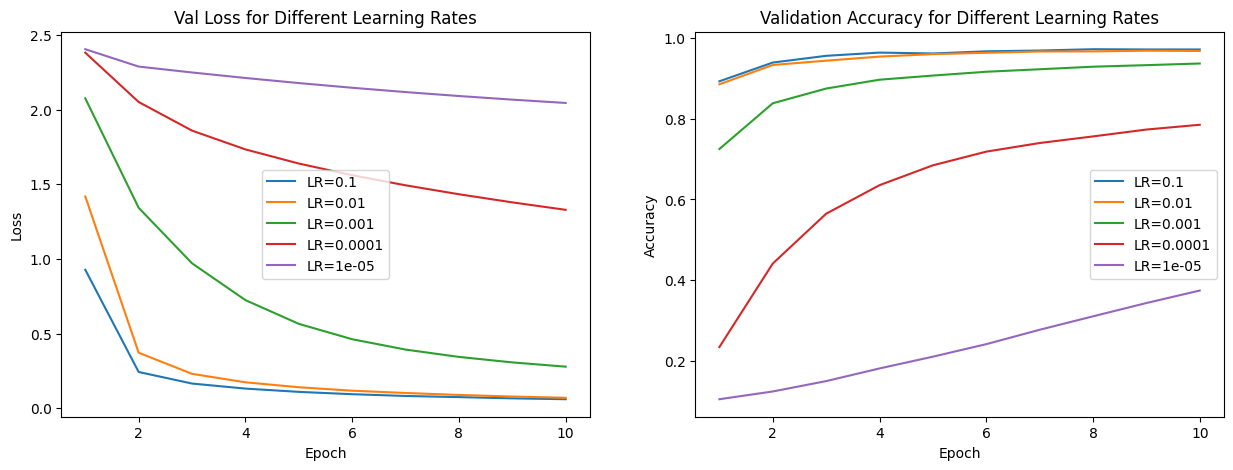

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
for i, lr in enumerate(learning_rates):
    plt.plot(range(1, num_of_epochs + 1), all_train_losses[i], label=f'LR={lr}')
plt.title('Val Loss for Different Learning Rates')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
for i, lr in enumerate(learning_rates):
    plt.plot(range(1, num_of_epochs + 1), all_val_accuracies[i], label=f'LR={lr}')
plt.title('Validation Accuracy for Different Learning Rates')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

**-Higher Learning Rates (e.g., 0.1):**

Training Loss: May decrease rapidly initially but may oscillate or diverge.
Validation Accuracy: May fluctuate, and the model might not converge to an optimal solution.
Overfitting: Higher risk of divergence and poor generalization.
Computational Efficiency: Faster initial updates but may require careful tuning.
Convergence Speed: Faster initial convergence, but stability is a concern.

**-Moderate Learning Rates (e.g., 0.0001):**

Training Loss: Decreases steadily without oscillations or divergence.
Validation Accuracy: Shows stable improvement, and the model converges well.
Overfitting: Moderate risk; better generalization compared to high learning rates.
Computational Efficiency: Efficient updates with a balance between speed and stability.
Convergence Speed: Moderate convergence speed with good stability.

-Lower Learning Rates (e.g., 0.000001):

Training Loss: Decreases more slowly but steadily.
Validation Accuracy: Improves steadily with a higher likelihood of convergence.
Overfitting: Lower risk, tends to generalize well.
Computational Efficiency: Slower updates, but stability is prioritized.
Convergence Speed: Slower but more stable convergence.

as we can see the optimal lr is 0.1

now we will try different batch sizes

In [ ]:
batch_sizes = [32, 64, 128, 256, 512]
all_train_losses = []
all_train_accuracies = []
all_val_losses = []
all_val_accuracies = []

for batch_size in batch_sizes:
    model = FlexibleNN(input_size, output_size, hidden_layers)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    optimizer = SGD(model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_of_epochs):
        train_loss, train_accuracy = train_model(model, train_loader, criterion, optimizer)
        val_loss, val_accuracy = validate(model, val_loader, criterion)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print("Epoch {}/{} - Batch Size: {}: Train Loss: {:.4f}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}".format(
            epoch + 1, num_of_epochs, batch_size, train_loss, val_loss, val_accuracy))
    all_train_losses.append(train_losses)
    all_train_accuracies.append(train_accuracies)
    all_val_losses.append(val_losses)
    all_val_accuracies.append(val_accuracies)


Epoch 1/10 - Batch Size: 32: Train Loss: 1.1597, Validation Loss: 0.4261, Validation Accuracy: 0.8963
Epoch 2/10 - Batch Size: 32: Train Loss: 0.2819, Validation Loss: 0.2081, Validation Accuracy: 0.9403
Epoch 3/10 - Batch Size: 32: Train Loss: 0.1765, Validation Loss: 0.1543, Validation Accuracy: 0.9559
Epoch 4/10 - Batch Size: 32: Train Loss: 0.1351, Validation Loss: 0.1403, Validation Accuracy: 0.9611
Epoch 5/10 - Batch Size: 32: Train Loss: 0.1089, Validation Loss: 0.1251, Validation Accuracy: 0.9638
Epoch 6/10 - Batch Size: 32: Train Loss: 0.0935, Validation Loss: 0.1142, Validation Accuracy: 0.9666
Epoch 7/10 - Batch Size: 32: Train Loss: 0.0809, Validation Loss: 0.1064, Validation Accuracy: 0.9689
Epoch 8/10 - Batch Size: 32: Train Loss: 0.0722, Validation Loss: 0.1056, Validation Accuracy: 0.9680
Epoch 9/10 - Batch Size: 32: Train Loss: 0.0640, Validation Loss: 0.0967, Validation Accuracy: 0.9712
Epoch 10/10 - Batch Size: 32: Train Loss: 0.0574, Validation Loss: 0.1016, Validat

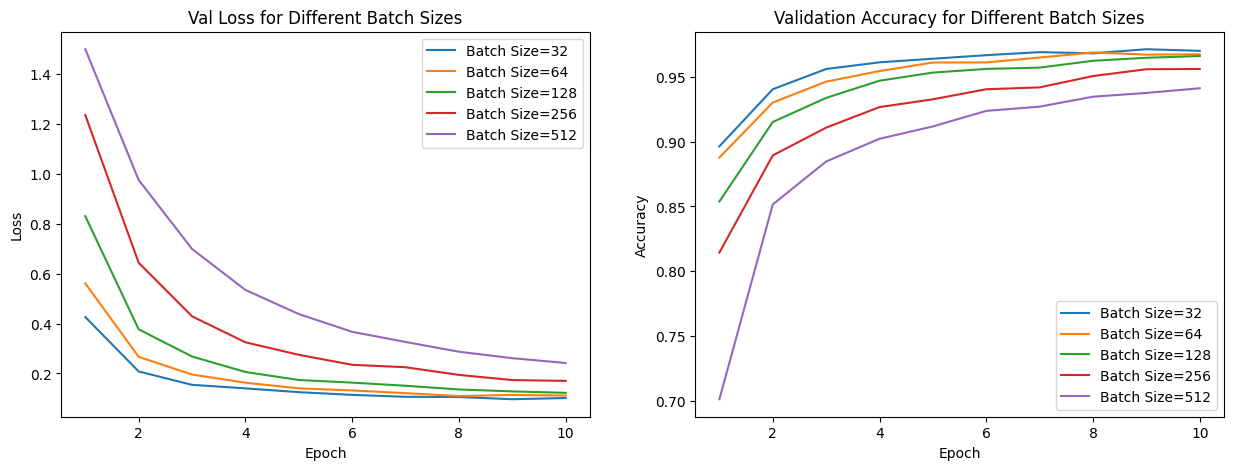

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
for i, batch_size in enumerate(batch_sizes):
    plt.plot(range(1, num_of_epochs + 1), all_val_losses[i], label=f'Batch Size={batch_size}')
plt.title('Val Loss for Different Batch Sizes')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
for i, batch_size in enumerate(batch_sizes):
    plt.plot(range(1, num_of_epochs + 1), all_val_accuracies[i], label=f'Batch Size={batch_size}')
plt.title('Validation Accuracy for Different Batch Sizes')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

**-Smaller Batch Sizes (e.g., 32, 64):**

Training Loss: Decreases more erratically due to noisy updates.
Validation Accuracy: May achieve higher accuracy initially but has a risk of overfitting.
Overfitting: Higher risk due to quicker adaptation to the training data.
Computational Efficiency: Faster updates but potentially less GPU utilization.
Convergence Speed: Faster convergence but may converge to a suboptimal solution quickly.

-Larger Batch Sizes (e.g., 256, 512):

Training Loss: Decreases more steadily, resulting in smoother convergence.
Validation Accuracy: May increase more steadily and generalize better.
Overfitting: Lower risk due to a more representative sample in each update.
Computational Efficiency: More GPU utilization, potentially faster overall training time.
Convergence Speed: Slower convergence in terms of updates per epoch but may converge to a more stable solution.